# Merge of IGN and Bugianen, Ecrins area

This file is identical to `merge_frit4` except with `fritN=3`  and this description :-)

* French side: IGNt3 ie a specific area downloaded from geoportail
* Italian side: Bugianen 2205 - roughly Germanasca & Monviso
  (all merged, check `maki-Sorbetto-merge.ipynb`)

Steps overview
* Cut Bugianen_merged to the same latitudes as the IGN side
* z14/z15/16 - merge along border
* z13: clean & merge it < fr
* z<12: add IGN basemap as Bugianen has nothing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import exists, join as pjoin, realpath
NBROOT = realpath(os.curdir)

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

import sys
sys.path.append(realpath('..'))
sys.path.append(realpath('../../eslope/development/src'))

import json
from pathlib import Path
from time import time
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve
from subprocess import check_call, CalledProcessError

try:
    # like os.system but with live output
    from IPython.utils.process import system
    def check_run(cmd):  # type:ignore
        r = system(cmd)
        if r: raise CalledProcessError(r, cmd)
        return r
except ImportError:
    def check_run(cmd):
        return check_call(cmd, shell=True)

#external
#!pip install shapely
import shapely
from shapely.geometry import mapping, shape, GeometryCollection, Polygon, Point
from shapely.ops import cascaded_union
import numpy as np
from IPython.display import display, Image
from PIL import Image as Img
import mercantile as T
from osgeo import gdal
gdal.UseExceptions()

# own
import mbt_util as M
import bbox
from mbt_util import mbt_merge, mbt_info
from src import img_util as G, geometry as GY, \
    mbt_download as MD, mbt_partial as MP, mbt_pyramid as MY, swisstopo as SS


In [3]:
mbtnames_fr = {
    1: 'IGNt1-Mercantour-Ubaye-Antibes-Embrun.mbtiles',  # 1.3GB
    # Préalpes, Trois-Evéchés, Pelat, Mercantour-Argentera, Parpaillon, Chambeyron
    2: 'IGNt2-Digne-Aups-Eguilles-Gap.mbtiles',  # 1.3 GB
    # Préalpes de Digne, Lubéron, Vaucluse, Baronnies, Bochaine, Diois-S
    3: 'IGNt3-Vercors-Ecrins-Cerces.mbtiles',  # 1.2
    # Vercors, Taillefer, Dévoluy, Ecrins, Cerces, Queyras, Escreins
    # coupé en 2 t3/t4: Grandes Rousses, Arves, Cerces
    4: 'IGNt4-Chartreuse-Vanoise Chambery-Bardon.mbtiles',  # 1 GB
    # Chartreuse, Belledonne, Grandes Rousses N, Arves N, Cerces N, Lauzière, Vanoise, Mont-Cenis
    5: 'IGNt5-MontBlanc-Chambery-Evian.mbtiles'  # 1.1 GB
    # Bauges, Beaufortain, Bornes, Aravis, Mont-Blanc, Aiguilles Rouges, Giffre, Chablais
}
mbtnames_merged = GY.bbalp_names

In [4]:
# This could be useful to restrict the area to merge to speed it up
border_zones = {
    4: dict(west=6.62, east=7.19),
    3: dict(west= 6.64, east=7.08),
    1: dict(west=6.85, east=7.72)  # instead of 8.174 for bug
}

In [5]:
fritN = 3
workdir = f'frit{fritN}'
os.makedirs(workdir, exist_ok=True)

orig = pjoin(realpath('../../mapdata/mobac_atlases'), mbtnames_fr[fritN])
mbtfr = pjoin(workdir, f'fr{fritN}.mbtiles')
!ln -sf "$orig" "$mbtfr"
M.mbt_info(mbtfr)

'zoom = 9 16 ; n = 55476 * 20 kb/tile ; bounds = 4.922,44.590,7.732,45.089 ; format = jpg ; name = IGNt3-Vercors-Ecrins-Cerces'

In [6]:
# this map contains z9-11 of enlarged Metropolitan France (-5 42.3 8.6 51.1)
mbtwalpsz9 = pjoin(realpath('../../mapdata/mobac_atlases'), 'IGN-fr-z9-12.mbtiles')
#also 'IGN-walps-z9-10.mbtiles'
M.mbt_info(mbtwalpsz9)

'zoom = 9 12 ; n = 27429 ; bounds = 4.92188,44.59047,7.73438,45.08904 ; center = 6.32813,44.83975,9 ; format = jpg ; name = Unnamed atlas'

In [7]:
mbtitall = '../../mapdata/mbtiles/Bugianen.mbtiles'
M.mbt_info(mbtitall)

'zoom = 12 16 ; n = 152742 ; bounds = 6.5918,44.59047,7.55859,45.08904 ; center = 7.07520,44.83975,12 ; format = jpg ; name = Bugianen'

In [8]:
bbfr = M.real_bounds(mbtfr)
bballit = M.real_bounds(mbtitall)
print("bbfr", bbfr)
# bbitcut = bbfr._replace(east=bballit.east)
bbitcut = GY.bbalps[fritN]

print("bbcutit", bbitcut)
mbtitcut = pjoin(workdir, "itcutN.mbtiles")
! rm -f $mbtitcut
M.cut_to_lnglat(mbtitall, mbtitcut, bbitcut) #, zmin=14)

# it's tricky to not get extra tiles, see `epsilon` in cut_to_lng_lat

bbfr LngLatBbox(west=4.921875, south=44.59046718130884, east=7.73437500000001, north=45.08903556483102)
bbcutit LngLatBbox(west=4.921875, south=44.59046718130884, east=8.789062500000012, north=45.08903556483102)
12 16 16
12 2123 <> 2147 2616 <> 2623
z 12 : added 68
13 4246 <> 4295 5232 <> 5247
z 13 : added 272
14 8492 <> 8591 10464 <> 10495
z 14 : added 1088
15 16984 <> 17183 20928 <> 20991
z 15 : added 4352
16 33968 <> 34367 41856 <> 41983
z 16 : added 17408
real bounds: LngLatBbox(west=6.591796874999988, south=44.59046718130884, east=7.558593750000012, north=45.08903556483102)
{'bounds': '6.5918,44.59047,7.55859,45.08904',
 'center': '7.07520,44.83975,12',
 'type': 'baselayer'}


In [9]:
bbfrit = bbfr._replace(east=M.real_bounds(mbtitcut).east)
bbfrit

LngLatBbox(west=4.921875, south=44.59046718130884, east=7.558593750000012, north=45.08903556483102)

In [10]:
# fill up the gaps at lower zoom levels

mbtbasemap = pjoin(workdir, 'basemap.mbtiles')
!rm -f $mbtbasemap
M.cut_to_lnglat(mbtwalpsz9, mbtbasemap, bbfrit, zmin=10)
mbtbasemapclean, reasons = MP.clean_missing_data(mbtbasemap, w=0.1, T=192)
reasons

9 12 12
9 263 <> 266 327 <> 327
z 9 : added 4
10 526 <> 533 654 <> 655
z 10 : added 16
11 1052 <> 1066 1308 <> 1311
z 11 : added 60
12 2104 <> 2133 2616 <> 2623
z 12 : added 240
real bounds: LngLatBbox(west=4.921875, south=44.59046718130884, east=7.73437500000001, north=45.08903556483102)
{'bounds': '4.92188,44.59047,7.73438,45.08904',
 'center': '6.32813,44.83975,9',
 'type': 'baselayer'}
Deleted 0. Status: 0 / 320
Deleted 0. Status: done!


defaultdict(int, {'': 320})

In [11]:
#!gpxsee $mbtbasemap


In [12]:
#!gpxsee $mbtitcut

## Common to all zoom levels

Attempt to remove white tiles
becuse IGN tiles can have a lot of white esp. in flat areas (Geneva) we raise the requirement of partial tile to 30% white and 192 contiguous white pixels (75% of a side)

In [13]:
mbtfrclean, stats = MP.clean_missing_data(mbtfr, w=0.1, T=255, zlevels=(12,13))
mbtfrclean, stats

Deleted 0. Status: 0 / 55476
Deleted 8. Status: done!


('frit3/fr3-clean.mbtiles',
 defaultdict(int, {'': 816, 'partial': 7, 'white': 1}))

In [ ]:
# let's have a quick look at a "dumb" merge as it's much quicker
M.mbt_merge(mbtitcut, mbtfrclean, mbtbasemapclean, dest=pjoin(workdir, 'tmp.mbtiles'), name="1st try")

In [19]:
print(M.real_bounds(pjoin(workdir, 'tmp.mbtiles'), log=print))

real bounds  9 [4.92, 44.59, 7.73, 45.09]
real bounds  10 [4.92, 44.59, 7.73, 45.09]
real bounds  11 [4.92, 44.59, 7.56, 45.09]
real bounds  12 [4.92, 44.59, 7.56, 45.09]
real bounds  13 [5.27, 44.59, 7.56, 45.09]
real bounds  14 [5.27, 44.59, 7.56, 45.09]
real bounds  15 [5.27, 44.59, 7.56, 45.09]
real bounds  16 [5.27, 44.59, 7.56, 45.09]
LngLatBbox(west=4.921875, south=44.59046718130884, east=7.73437500000001, north=45.08903556483102)


In [ ]:
# This could be useful to restrict the area to merge to speed it up
border_zone = bbfr._replace(*border_zones[fritN])

## Geometry!

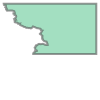

In [46]:
# cut french side from the italian bbox
it_to_keep = GY.bb2poly(bbfrit).difference(GY.frch)
it_to_keep

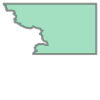

In [47]:

it_to_keep14 = it_to_keep.buffer(0.0006)
GY.sh2geojson(it_to_keep14, pjoin(workdir, 'it_to_keep14.geojson'))
it_to_keep14

In [23]:

it_to_keep15 = it_to_keep.buffer(0.0003)
GY.sh2geojson(it_to_keep15, pjoin(workdir, 'it_to_keep15.geojson'))

## Merge at z14/15/16

In [51]:
def runc(cmd):
    start = time()
    print(cmd)
    check_run(cmd)
    print(f'{time()-start:.1f} seconds')

In [55]:

z_to_process = (14, 15, 16)
optmulti = '-multi -wo NUM_THREADS=ALL_CPUS'

for zlevel in z_to_process:
    # generate vrt italian side
    k = min(zlevel, 15)
    vrt = f"{workdir}/it{zlevel}.vrt"
    runc(f'''gdalwarp -cutline {workdir}/it_to_keep{k}.geojson -crop_to_cutline \
        {mbtitcut} -oo ZOOM_LEVEL={zlevel} {vrt} -overwrite''')

    # apply on top of france, in 2 steps to work around issue gdal#7067
    mrg = f"{workdir}/mrg{zlevel}"
    runc(f'''gdalwarp {mbtfrclean} -oo ZOOM_LEVEL={zlevel} {vrt} {mrg}.tif -co TILED=yes -overwrite {optmulti}''')
    runc(f'''gdal_translate {mrg}.tif {mrg}.mbtiles -co TILE_FORMAT=JPEG -co QUALITY=95''')
    mbt_info(mrg + '.mbtiles')
# for z16, ~20 minutes for the warp + 8 for the translate ; creates an intermediate 14 GB file :-|

gdalwarp -cutline frit3//it_to_keep14.geojson -crop_to_cutline         frit3/itcutN.mbtiles -oo ZOOM_LEVEL=14 frit3//it14.vrt -overwrite
Using band 4 of source image as alpha.
Creating output file that is 12583P x 8210L.
Processing frit3/itcutN.mbtiles [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0.4 seconds
gdalwarp frit3/ignclean.mbtiles -oo ZOOM_LEVEL=14 frit3//it14.vrt frit3//mrg14.tif -co TILED=yes -overwrite 
Warning 6: driver VRT does not support open option ZOOM_LEVEL
Creating output file that is 32739P x 8210L.
Using band 4 of destination image as alpha.
Processing frit3/ignclean.mbtiles [1/2] : 0Using band 4 of source image as alpha.
...10...20...30...40...50...60...70...80...90...100 - done.
Processing frit3//it14.vrt [2/2] : 0Using band 4 of source image as alpha.
...10...20...30...40...50...60...70...80...90...100 - done.
21.8 seconds
gdal_translate frit3//mrg14.tif frit3//mrg14.mbtiles -co TILE_FORMAT=JPEG -co QUALITY=95
Input file size is 32739, 8

*(keeping output for future reference)*
<details>

```

gdalwarp -cutline frit3//it_to_keep14.geojson -crop_to_cutline         frit3/itcutN.mbtiles -oo ZOOM_LEVEL=14 frit3//it14.vrt -overwrite
    Using band 4 of source image as alpha.
    Creating output file that is 12583P x 8210L.
    Processing frit3/itcutN.mbtiles [1/1] : 
    0.4 seconds
gdalwarp frit3/ignclean.mbtiles -oo ZOOM_LEVEL=14 frit3//it14.vrt frit3//mrg14.tif -co TILED=yes -overwrite 
    Warning 6: driver VRT does not support open option ZOOM_LEVEL
    Creating output file that is 32739P x 8210L.
    Using band 4 of destination image as alpha.
    Processing frit3/ignclean.mbtiles [1/2] : 0Using band 4 of source image as alpha.
    Processing frit3//it14.vrt [2/2] : 0Using band 4 of source image as alpha.
    21.8 seconds
gdal_translate frit3//mrg14.tif frit3//mrg14.mbtiles -co TILE_FORMAT=JPEG -co QUALITY=95
    Input file size is 32739, 8210
    38.9 seconds

gdalwarp -cutline frit3//it_to_keep15.geojson -crop_to_cutline         frit3/itcutN.mbtiles -oo ZOOM_LEVEL=15 frit3//it15.vrt -overwrite
    Using band 4 of source image as alpha.
    Creating output file that is 25152P x 16402L.
    Processing frit3/itcutN.mbtiles [1/1] : 
    0.6 seconds
gdalwarp frit3/ignclean.mbtiles -oo ZOOM_LEVEL=15 frit3//it15.vrt frit3//mrg15.tif -co TILED=yes -overwrite 
    Warning 6: driver VRT does not support open option ZOOM_LEVEL
    Creating output file that is 65478P x 16408L.
    Using band 4 of destination image as alpha.
    Processing frit3/ignclean.mbtiles [1/2] : 0Using band 4 of source image as alpha.
    Processing frit3//it15.vrt [2/2] : 0Using band 4 of source image as alpha.
    129.6 seconds
gdal_translate frit3//mrg15.tif frit3//mrg15.mbtiles -co TILE_FORMAT=JPEG -co QUALITY=95
    Input file size is 65478, 16408
    139.9 seconds

gdalwarp -cutline frit3//it_to_keep15.geojson -crop_to_cutline         frit3/itcutN.mbtiles -oo ZOOM_LEVEL=16 frit3//it16.vrt -overwrite
    Using band 4 of source image as alpha.
    Creating output file that is 50306P x 32806L.
    Processing frit3/itcutN.mbtiles [1/1] : 
    1.1 seconds
gdalwarp frit3/ignclean.mbtiles -oo ZOOM_LEVEL=16 frit3//it16.vrt frit3//mrg16.tif -co TILED=yes -overwrite 
    Warning 6: driver VRT does not support open option ZOOM_LEVEL
    Creating output file that is 130955P x 32818L.
    Using band 4 of destination image as alpha.
    Processing frit3/ignclean.mbtiles [1/2] : 0Using band 4 of source image as alpha.
    Processing frit3//it16.vrt [2/2] : 0Using band 4 of source image as alpha.
    731.5 seconds
gdal_translate frit3//mrg16.tif frit3//mrg16.mbtiles -co TILE_FORMAT=JPEG -co QUALITY=95
    Input file size is 130955, 32818
    532.8 seconds
```

</details>

In [6]:
finalname = mbtnames_merged[fritN]
finalpath = pjoin(workdir, finalname + '.mbtiles')

In [30]:
# !rm $finalpath

mbt_merge(
    mbtitcut,
    mbtfrclean,
    pjoin(workdir, 'mrg14.mbtiles'),
    pjoin(workdir, 'mrg15.mbtiles'),
    pjoin(workdir, 'mrg16.mbtiles'),
    mbtbasemapclean,  # overrides z12 of mbtit
    dest=finalpath,
    name=finalname,
)

cp frit3/itcutN.mbtiles frit3/alps3-Vercors-Ecrins-Queyras-Cozie.mbtiles
<<>> frit3/itcutN : zoom = 12 16 ; n = 23188 ; bounds = 6.5918,44.59047,7.55859,45.08904 ; center = 7.07520,44.83975,12 ; format = jpg ; name = Bugianen
<< frit3/fr3-clean : zoom = 9 16 ; n = 55468 ; bounds = 4.922,44.590,7.732,45.089 ; format = jpg ; name = IGNt3-Vercors-Ecrins-Cerces
>> frit3/alps3-Vercors-Ecrins-Queyras-Cozie : zoom = 9 16 ; n = 68260 ; bounds = 6.5918,44.59047,7.55859,45.08904 ; center = 7.07520,44.83975,12 ; format = jpg ; name = Bugianen
<< frit3/mrg14 : zoom = 14 14 ; n = 3200 ; name = mrg14 ; format = jpg ; bounds = 4.92199999999999971,44.5899215390543162,7.7320109100341794,45.0895853710405135
>> frit3/alps3-Vercors-Ecrins-Queyras-Cozie : zoom = 9 16 ; n = 68260 ; bounds = 6.5918,44.59047,7.55859,45.08904 ; center = 7.07520,44.83975,12 ; format = jpg ; name = Bugianen
<< frit3/mrg15 : zoom = 15 15 ; n = 12800 ; name = mrg15 ; format = jpg ; bounds = 4.92199999999999971,44.5900132254106651,

In [ ]:
M.real_bounds(finalpath, log=print)

real bounds  9 [4.92, 44.59, 7.73, 45.09] 263 327 266 327
real bounds  10 [4.92, 44.59, 7.73, 45.09] 526 654 533 655
real bounds  11 [4.92, 44.59, 7.56, 45.09] 1052 1308 1066 1311
real bounds  12 [4.92, 44.59, 7.56, 45.09] 2104 2616 2133 2623
real bounds  13 [5.27, 44.59, 7.56, 45.09] 4216 5232 4267 5247
real bounds  14 [5.27, 44.59, 7.56, 45.09] 8432 10464 8535 10495
real bounds  15 [5.27, 44.59, 7.56, 45.09] 16864 20928 17071 20991
real bounds  16 [5.27, 44.59, 7.56, 45.09] 33728 41855 34143 41983


LngLatBbox(west=4.921875, south=44.586555132095434, east=7.73437500000001, north=45.08903556483102)

In [7]:
description = finalname[6:] + ''' area, fusion de cartes IGN et Bugianen:
* IGN Top 25 et top 100 (2021)
* Bugianen 2205 : Mappa escursionistica delle alpi piemontesi, valdostane e dintorni.
Per la legenda e l'origine dei dati visita '''\
'<a href="https://tartamillo.wordpress.com/bugianen/">tartamillo.wordpress.com/bugianen/</a>.'
attribution = '© <a href="https://geoservices.ign.fr/cgu-licences">IGN 2021</a> '\
    '/ © <a href="https://tartamillo.wordpress.com/bugianen/">CC BY-NC-SA 3.0 Maki</a>'
M.update_mbt_meta(finalpath, name=finalname, desc=description, attrib=attribution)

In [8]:
M.get_meta(finalpath)

{'bounds': '4.92188,44.58656,7.73438,45.08904',
 'name': 'alps3-Vercors-Ecrins-Queyras-Cozie',
 'type': 'baselayer',
 'version': '1.1',
 'description': 'Vercors-Ecrins-Queyras-Cozie area, fusion de cartes IGN et Bugianen:\n* IGN Top 25 et top 100 (2021)\n* Bugianen 2205 : Mappa escursionistica delle alpi piemontesi, valdostane e dintorni.\nPer la legenda e l\'origine dei dati visita <a href="https://tartamillo.wordpress.com/bugianen/">tartamillo.wordpress.com/bugianen/</a>.',
 'format': 'jpg',
 'attribution': '© <a href="https://geoservices.ign.fr/cgu-licences">IGN 2021</a> / © <a href="https://tartamillo.wordpress.com/bugianen/">CC BY-NC-SA 3.0 Maki</a>',
 'maxzoom': '16',
 'minzoom': '12',
 'center': '6.32813,44.83780,9'}

In [24]:
#!gpxsee $finalpath